In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No OBV LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4106, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[0.03424644, 0.56561183, 0.46282749],
       [0.31506791, 0.48559383, 0.32255128],
       [0.        , 0.19792211, 0.        ],
       [0.28082311, 0.1505638 , 0.19881152],
       [0.73972344, 0.43087195, 0.52369458],
       [0.52739485, 0.5198189 , 0.37337444],
       [0.15068401, 0.33208159, 0.10667825],
       [0.14383571, 0.16844582, 0.12955741],
       [0.26712158, 0.11605662, 0.33580412],
       [0.16438226, 0.        , 0.3783434 ],
       [0.58904107, 0.19827315, 0.83077978],
       [0.85616429, 0.55253441, 1.        ],
       [0.5068483 , 0.6084195 , 0.60041228],
       [1.        , 1.        , 0.93732045],
       [0.17808379, 0.75751779, 0.04412728]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4106,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 38ms/step - loss: 0.2997 - accuracy: 0.5308 - mse: 0.4471 - weighted_accuracy: 0.3153 - weighted_mse: 0.5326 - val_loss: 0.3013 - val_accuracy: 0.0450 - val_mse: 0.3490 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3490
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2128 - accuracy: 0.3752 - mse: 0.7453 - weighted_accuracy: 0.4331 - weighted_mse: 0.7541 - val_loss: 0.2936 - val_accuracy: 0.0450 - val_mse: 0.3738 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3738
Epoch 3/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1914 - accuracy: 0.2865 - mse: 0.9782 - weighted_accuracy: 0.4606 - weighted_mse: 0.9610 - val_loss: 0.2848 - val_accuracy: 0.0450 - val_mse: 0.4060 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4060
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1821 - accuracy: 0.2537 - mse: 1.1121 - weighted_accuracy: 0.5027 - weighte

Epoch 30/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1391 - accuracy: 0.3767 - mse: 1.7276 - weighted_accuracy: 0.7074 - weighted_mse: 1.6302 - val_loss: 0.1901 - val_accuracy: 0.3309 - val_mse: 1.6528 - val_weighted_accuracy: 0.3309 - val_weighted_mse: 1.6528
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.3946 - mse: 1.7522 - weighted_accuracy: 0.7182 - weighted_mse: 1.6579 - val_loss: 0.2044 - val_accuracy: 0.2883 - val_mse: 1.7358 - val_weighted_accuracy: 0.2883 - val_weighted_mse: 1.7358
Epoch 32/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1377 - accuracy: 0.3922 - mse: 1.7638 - weighted_accuracy: 0.6937 - weighted_mse: 1.6735 - val_loss: 0.1938 - val_accuracy: 0.3333 - val_mse: 1.7724 - val_weighted_accuracy: 0.3333 - val_weighted_mse: 1.7724
Epoch 33/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1354 - accuracy: 0.3965 - mse: 1.7762 - weighted_accuracy: 0.7124 - weig

Epoch 59/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1185 - accuracy: 0.5216 - mse: 2.1890 - weighted_accuracy: 0.7863 - weighted_mse: 2.1232 - val_loss: 0.1930 - val_accuracy: 0.4161 - val_mse: 2.3941 - val_weighted_accuracy: 0.4161 - val_weighted_mse: 2.3941
Epoch 60/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.5174 - mse: 2.2367 - weighted_accuracy: 0.7804 - weighted_mse: 2.1658 - val_loss: 0.2118 - val_accuracy: 0.3516 - val_mse: 2.2695 - val_weighted_accuracy: 0.3516 - val_weighted_mse: 2.2695
Epoch 61/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1173 - accuracy: 0.5040 - mse: 2.2525 - weighted_accuracy: 0.7690 - weighted_mse: 2.1867 - val_loss: 0.1652 - val_accuracy: 0.5389 - val_mse: 2.1871 - val_weighted_accuracy: 0.5389 - val_weighted_mse: 2.1871
Epoch 62/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1185 - accuracy: 0.5107 - mse: 2.2749 - weighted_accuracy: 0.7779 - weig

Epoch 88/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.6248 - mse: 2.8771 - weighted_accuracy: 0.8390 - weighted_mse: 2.8399 - val_loss: 0.2125 - val_accuracy: 0.4331 - val_mse: 3.0438 - val_weighted_accuracy: 0.4331 - val_weighted_mse: 3.0438
Epoch 89/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0997 - accuracy: 0.6382 - mse: 2.8513 - weighted_accuracy: 0.8395 - weighted_mse: 2.8261 - val_loss: 0.1974 - val_accuracy: 0.5097 - val_mse: 2.8600 - val_weighted_accuracy: 0.5097 - val_weighted_mse: 2.8600
Epoch 90/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0996 - accuracy: 0.6127 - mse: 2.9272 - weighted_accuracy: 0.8303 - weighted_mse: 2.8730 - val_loss: 0.1719 - val_accuracy: 0.5669 - val_mse: 3.1095 - val_weighted_accuracy: 0.5669 - val_weighted_mse: 3.1095
Epoch 91/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0971 - accuracy: 0.6355 - mse: 2.9169 - weighted_accuracy: 0.8515 - 

Epoch 117/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0853 - accuracy: 0.7010 - mse: 3.7952 - weighted_accuracy: 0.8668 - weighted_mse: 3.7370 - val_loss: 0.1709 - val_accuracy: 0.6180 - val_mse: 3.9258 - val_weighted_accuracy: 0.6180 - val_weighted_mse: 3.9258
Epoch 118/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0834 - accuracy: 0.7104 - mse: 3.8376 - weighted_accuracy: 0.8725 - weighted_mse: 3.7541 - val_loss: 0.1607 - val_accuracy: 0.6825 - val_mse: 4.2232 - val_weighted_accuracy: 0.6825 - val_weighted_mse: 4.2232
Epoch 119/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0832 - accuracy: 0.6928 - mse: 3.8209 - weighted_accuracy: 0.8703 - weighted_mse: 3.7265 - val_loss: 0.1577 - val_accuracy: 0.6849 - val_mse: 4.2131 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 4.2131
Epoch 120/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0844 - accuracy: 0.7086 - mse: 3.8653 - weighted_accuracy: 0.878

Epoch 146/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0712 - accuracy: 0.7786 - mse: 4.8472 - weighted_accuracy: 0.8953 - weighted_mse: 4.6971 - val_loss: 0.2394 - val_accuracy: 0.5292 - val_mse: 4.7291 - val_weighted_accuracy: 0.5292 - val_weighted_mse: 4.7291
Epoch 147/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0703 - accuracy: 0.7570 - mse: 4.8464 - weighted_accuracy: 0.9046 - weighted_mse: 4.6991 - val_loss: 0.1571 - val_accuracy: 0.7056 - val_mse: 5.2051 - val_weighted_accuracy: 0.7056 - val_weighted_mse: 5.2051
Epoch 148/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0711 - accuracy: 0.7628 - mse: 4.8592 - weighted_accuracy: 0.8959 - weighted_mse: 4.7003 - val_loss: 0.1887 - val_accuracy: 0.6277 - val_mse: 5.0117 - val_weighted_accuracy: 0.6277 - val_weighted_mse: 5.0117
Epoch 149/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0701 - accuracy: 0.7628 - mse: 4.9035 - weighted_accuracy: 0.898

Epoch 175/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0585 - accuracy: 0.8213 - mse: 6.1407 - weighted_accuracy: 0.9259 - weighted_mse: 5.8484 - val_loss: 0.2577 - val_accuracy: 0.5791 - val_mse: 6.2890 - val_weighted_accuracy: 0.5791 - val_weighted_mse: 6.2890
Epoch 176/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0590 - accuracy: 0.8188 - mse: 6.1625 - weighted_accuracy: 0.9293 - weighted_mse: 5.9319 - val_loss: 0.1831 - val_accuracy: 0.6849 - val_mse: 6.4406 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 6.4406
Epoch 177/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0565 - accuracy: 0.8377 - mse: 6.2300 - weighted_accuracy: 0.9298 - weighted_mse: 5.9550 - val_loss: 0.2063 - val_accuracy: 0.6375 - val_mse: 7.0173 - val_weighted_accuracy: 0.6375 - val_weighted_mse: 7.0173
Epoch 178/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0585 - accuracy: 0.8188 - mse: 6.3611 - weighted_accuracy: 0.922

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20569084584712982
Test accuracy: 0.6788321137428284


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.1358008  -2.536497    0.8715979 ]
 [-2.7003706  -1.3336807  -0.24356487]
 [-2.111282   -2.269958    1.2352287 ]
 ...
 [-3.8384285  -5.286337    3.3138278 ]
 [-1.7844697  -4.413475    0.7068466 ]
 [-2.7653823  -3.474627    1.408969  ]]


Counter({2: 606, 0: 106, 1: 110})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 30
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 29
actual holds but predicted buy: 99
actual holds but predicted sell: 102
actual predicted holds: 547
Percentage buys correct: 18.91891891891892%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 73.1283422459893%
actual buys: 37
actual sells: 37
actual holds: 748


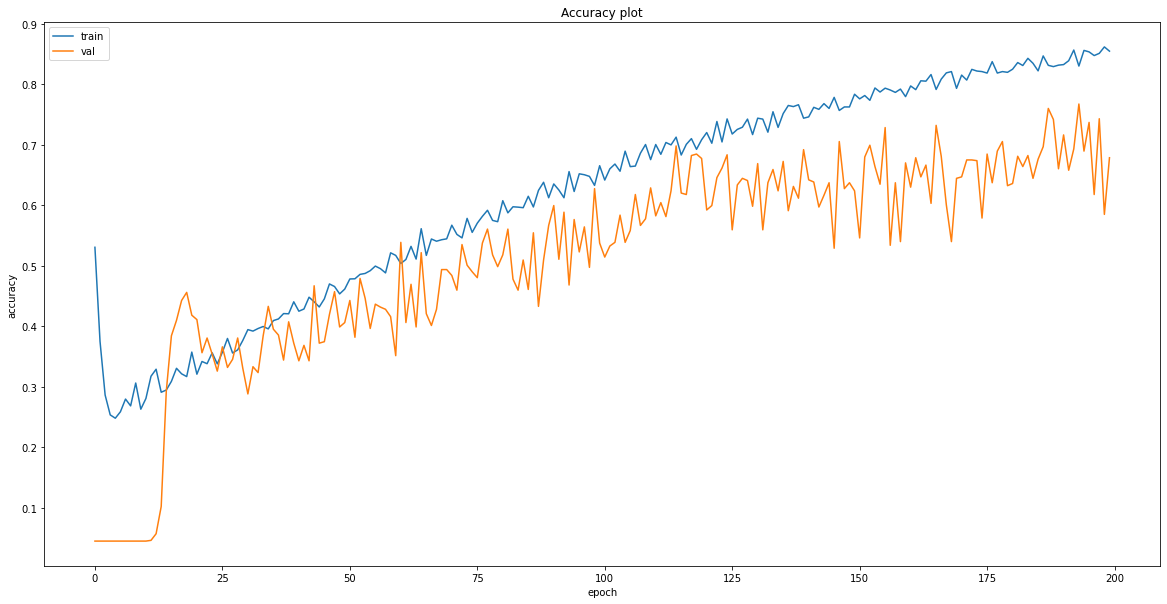

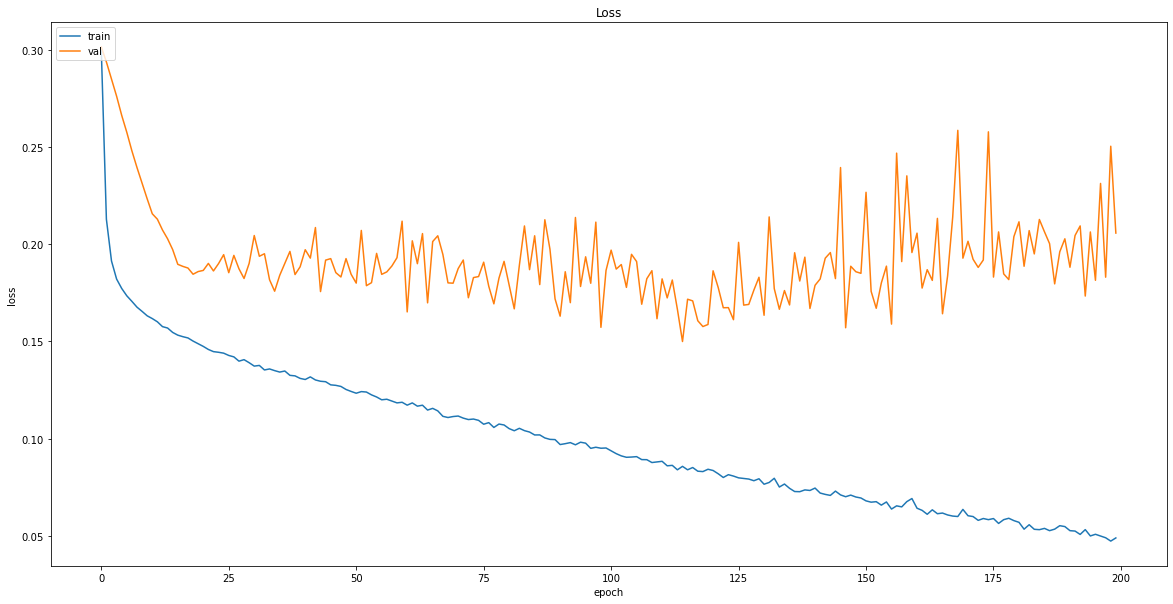

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_no_obv.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [26]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.7198 - mean_squared_error: 8.5982 - weighted_accuracy: 0.7198 - weighted_mean_squared_error: 8.5982
Test loss: 0.204970583319664
Test accuracy: 0.7198067903518677


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 161, 1: 20, 0: 26})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [33]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-15,724.780029,700.682442,-8.071529,46243699.0,2.0,2,2
2019-02-18,740.000000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.760010,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.000000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.250000,714.454318,-29.824573,40956103.0,2.0,1,2


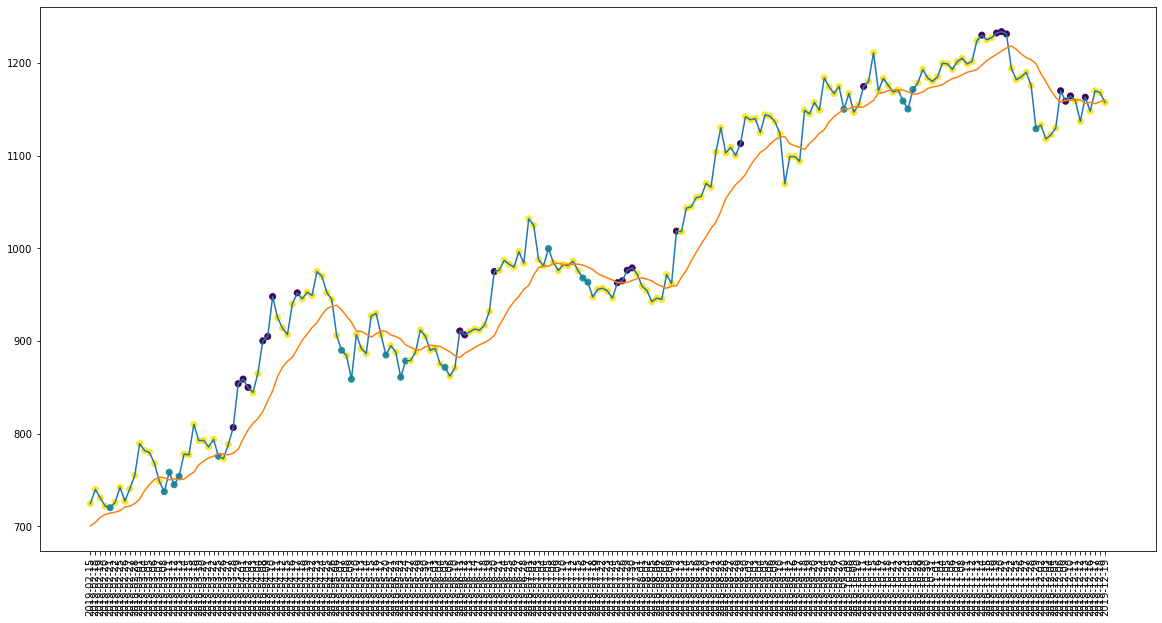

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 24
actual predicted holds: 144
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 77.83783783783784%
actual buys: 11
actual sells: 11
actual holds: 185


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 75.0%
Percentage sells correct: 65.38461538461539%
Percentage holds correct: 86.95652173913044%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $720.25
Shares owned at the moment: 13
Cash capital at the moment: $611.0010624999995


Price increase from previously bought: 11.709458176819542%
Share price: $806.7999877929688
Shares owned at the moment: 0
Cash capital at the moment: $11070.557804244994


Share price: $890.0
Shares owned at the moment: 12
Cash capital at the moment: $361.18780424499346


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $10638.567045028685


Share price: $858.8099975585938
Shares owned at the moment: 12
Cash capital at the moment: $304.506344406127


Price increase from previously bought: 5.773330469432514%
Share price: $910.8900146484376
Shares owned at the moment: 0
Cash capital at the moment: $11205.12714970398


Share price: $999.8200073242188
Shares owned at the moment: 11
Cash capital at the moment: $176.8625139160158


Stop Loss Activated!

Share price: $968.0
Shares owned at the moment: 0
Cash capital at the moment: $

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15556.77199960327
profit gained: 55.56771999603271%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [43]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.7452 - mean_squared_error: 7.5748 - weighted_accuracy: 0.7452 - weighted_mean_squared_error: 7.5748
Test loss: 0.1410638391971588
Test accuracy: 0.745192289352417


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 163, 1: 9, 0: 36})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-18,1084.000000,1082.243470,-14.989967,2243205.0,2.0,2,2
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,0
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,2
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,1,2


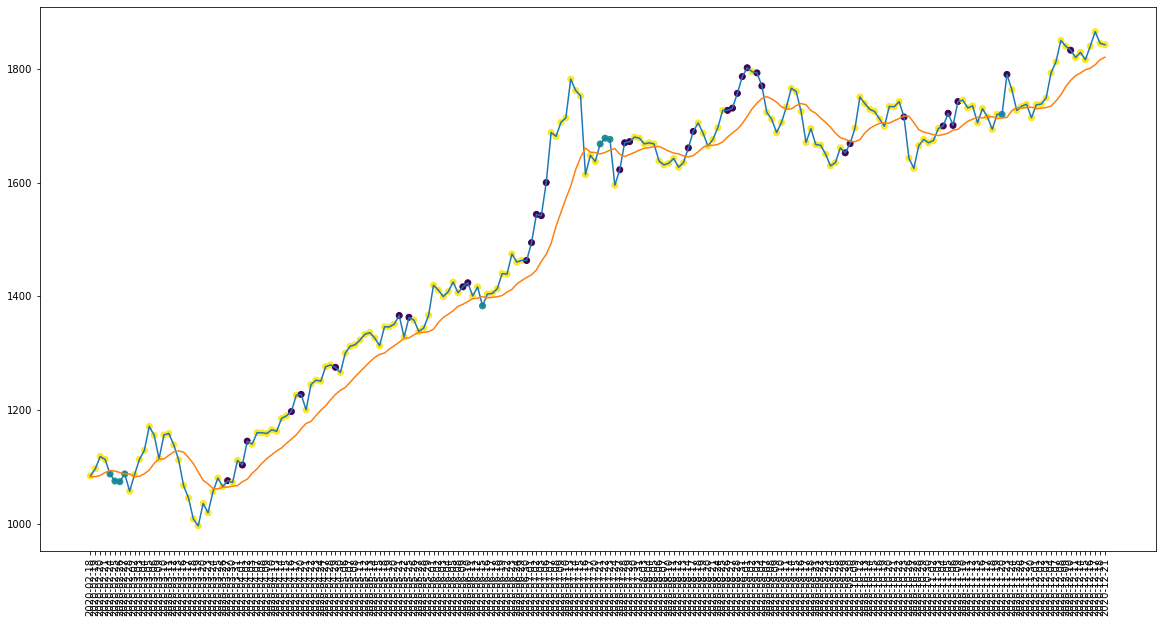

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 6
actual holds but predicted sell: 33
actual predicted holds: 150
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 30.0%
Percentage holds correct: 79.36507936507937%
actual buys: 9
actual sells: 10
actual holds: 189


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1084.0, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1073.699951171875, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1171.0]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 47.22222222222222%
Percentage holds correct: 84.04907975460122%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1087.1800537109377
Shares owned at the moment: 9
Cash capital at the moment: $188.4718102722145


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9675.311060272214


Share price: $1383.0
Shares owned at the moment: 6
Cash capital at the moment: $1354.491560272214


Price increase from previously bought: 5.485764104087054%
Share price: $1462.8800048828125
Shares owned at the moment: 0
Cash capital at the moment: $10107.634069488522


Share price: $1668.0
Shares owned at the moment: 6
Cash capital at the moment: $72.11206948852123


Stop Loss Activated!

Share price: $1595.300048828125
Shares owned at the moment: 0
Cash capital at the moment: $9617.589911651607


Share price: $1719.9599609375
Shares owned at the moment: 5
Cash capital at the moment: $994.1406575012152


Price increase from previously bought: 6.274181617750196%
Share price: $1832.9000244140625
Shares owned at the moment: 0
Cash capital at the moment: $101

In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16754.069125
profit gained: 67.54069125000002%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%


### Midea Group

In [58]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [60]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(1253, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 93ms/step - loss: 0.3448 - accuracy: 0.5739 - mse: 0.3407 - weighted_accuracy: 0.2876 - weighted_mse: 0.4519 - val_loss: 0.3040 - val_accuracy: 0.0518 - val_mse: 0.3406 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3406
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2838 - accuracy: 0.5659 - mse: 0.4074 - weighted_accuracy: 0.3559 - weighted_mse: 0.4789 - val_loss: 0.3035 - val_accuracy: 0.0438 - val_mse: 0.3439 - val_weighted_accuracy: 0.0438 - val_weighted_mse: 0.3439
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2472 - accuracy: 0.5210 - mse: 0.5059 - weighted_accuracy: 0.4193 - weighted_mse: 0.5399 - val_loss: 0.3014 - val_accuracy: 0.0518 - val_mse: 0.3466 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3466
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2228 - accuracy: 0.4760 - mse: 0.6069 - weighted_accuracy: 0.4653 - weighted_mse: 0

8/8 [==============================] - 0s 7ms/step - loss: 0.1421 - accuracy: 0.4711 - mse: 1.2927 - weighted_accuracy: 0.7220 - weighted_mse: 1.2222 - val_loss: 0.2339 - val_accuracy: 0.0518 - val_mse: 0.7487 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7487
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1413 - accuracy: 0.4651 - mse: 1.2928 - weighted_accuracy: 0.7338 - weighted_mse: 1.2256 - val_loss: 0.2324 - val_accuracy: 0.0518 - val_mse: 0.7719 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7719
Epoch 32/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.4910 - mse: 1.2958 - weighted_accuracy: 0.7358 - weighted_mse: 1.2316 - val_loss: 0.2318 - val_accuracy: 0.0518 - val_mse: 0.7992 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.7992
Epoch 33/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.4900 - mse: 1.3030 - weighted_accuracy: 0.7430 - weighted_mse: 1.2357 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.1117 - accuracy: 0.6188 - mse: 1.5507 - weighted_accuracy: 0.8322 - weighted_mse: 1.4758 - val_loss: 0.1938 - val_accuracy: 0.4183 - val_mse: 1.3838 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 1.3838
Epoch 60/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1126 - accuracy: 0.6287 - mse: 1.5538 - weighted_accuracy: 0.8230 - weighted_mse: 1.4847 - val_loss: 0.1931 - val_accuracy: 0.4382 - val_mse: 1.3950 - val_weighted_accuracy: 0.4382 - val_weighted_mse: 1.3950
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1102 - accuracy: 0.6337 - mse: 1.5655 - weighted_accuracy: 0.8377 - weighted_mse: 1.4869 - val_loss: 0.1933 - val_accuracy: 0.4263 - val_mse: 1.4099 - val_weighted_accuracy: 0.4263 - val_weighted_mse: 1.4099
Epoch 62/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1104 - accuracy: 0.6287 - mse: 1.5730 - weighted_accuracy: 0.8359 - weighted_mse: 1.4847 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0902 - accuracy: 0.7146 - mse: 1.9117 - weighted_accuracy: 0.8813 - weighted_mse: 1.8371 - val_loss: 0.1841 - val_accuracy: 0.5418 - val_mse: 1.8705 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.8705
Epoch 89/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0908 - accuracy: 0.7036 - mse: 1.9382 - weighted_accuracy: 0.8698 - weighted_mse: 1.8589 - val_loss: 0.1797 - val_accuracy: 0.5299 - val_mse: 1.9050 - val_weighted_accuracy: 0.5299 - val_weighted_mse: 1.9050
Epoch 90/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 0.7255 - mse: 1.9560 - weighted_accuracy: 0.8854 - weighted_mse: 1.8880 - val_loss: 0.1835 - val_accuracy: 0.5339 - val_mse: 1.9620 - val_weighted_accuracy: 0.5339 - val_weighted_mse: 1.9620
Epoch 91/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.7096 - mse: 1.9743 - weighted_accuracy: 0.8795 - weighted_mse: 1.8947 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.0722 - accuracy: 0.7735 - mse: 2.4409 - weighted_accuracy: 0.9169 - weighted_mse: 2.3427 - val_loss: 0.1751 - val_accuracy: 0.6335 - val_mse: 2.8301 - val_weighted_accuracy: 0.6335 - val_weighted_mse: 2.8301
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.7794 - mse: 2.4662 - weighted_accuracy: 0.9191 - weighted_mse: 2.3434 - val_loss: 0.1990 - val_accuracy: 0.5817 - val_mse: 2.8248 - val_weighted_accuracy: 0.5817 - val_weighted_mse: 2.8248
Epoch 119/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.7685 - mse: 2.4896 - weighted_accuracy: 0.9151 - weighted_mse: 2.3695 - val_loss: 0.1826 - val_accuracy: 0.6295 - val_mse: 2.9108 - val_weighted_accuracy: 0.6295 - val_weighted_mse: 2.9108
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.8034 - mse: 2.4880 - weighted_accuracy: 0.9279 - weighted_mse: 2.3705 -

Epoch 146/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.8114 - mse: 3.1269 - weighted_accuracy: 0.9308 - weighted_mse: 2.8994 - val_loss: 0.2041 - val_accuracy: 0.6215 - val_mse: 3.5865 - val_weighted_accuracy: 0.6215 - val_weighted_mse: 3.5865
Epoch 147/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.8253 - mse: 3.1637 - weighted_accuracy: 0.9360 - weighted_mse: 2.9236 - val_loss: 0.1891 - val_accuracy: 0.6534 - val_mse: 3.5079 - val_weighted_accuracy: 0.6534 - val_weighted_mse: 3.5079
Epoch 148/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.8353 - mse: 3.1792 - weighted_accuracy: 0.9396 - weighted_mse: 2.9616 - val_loss: 0.1830 - val_accuracy: 0.6892 - val_mse: 3.7087 - val_weighted_accuracy: 0.6892 - val_weighted_mse: 3.7087
Epoch 149/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.8323 - mse: 3.2333 - weighted_accuracy: 0.9385 - weighted

Epoch 175/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.8653 - mse: 4.0367 - weighted_accuracy: 0.9506 - weighted_mse: 3.6254 - val_loss: 0.1838 - val_accuracy: 0.7291 - val_mse: 4.9818 - val_weighted_accuracy: 0.7291 - val_weighted_mse: 4.9818
Epoch 176/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.8703 - mse: 4.0693 - weighted_accuracy: 0.9524 - weighted_mse: 3.6489 - val_loss: 0.2221 - val_accuracy: 0.6375 - val_mse: 4.4916 - val_weighted_accuracy: 0.6375 - val_weighted_mse: 4.4916
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0437 - accuracy: 0.8693 - mse: 4.0633 - weighted_accuracy: 0.9521 - weighted_mse: 3.6932 - val_loss: 0.2114 - val_accuracy: 0.6773 - val_mse: 4.6562 - val_weighted_accuracy: 0.6773 - val_weighted_mse: 4.6562
Epoch 178/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0424 - accuracy: 0.8842 - mse: 4.1168 - weighted_accuracy: 0.9576 - weighted

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.21740159392356873
Test accuracy: 0.737051784992218


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.97649455e+00 -3.28350902e+00  2.32324910e+00]
 [-1.18475056e+00 -2.81710553e+00  7.20432520e-01]
 [-1.03553164e+00 -6.84624135e-01 -6.88316286e-01]
 [-1.66430533e+00 -9.52221096e-01 -2.51370668e-01]
 [-1.33704305e+00 -1.14322698e+00 -4.60788250e-01]
 [-7.20157146e-01 -2.07720637e+00 -4.36054349e-01]
 [-4.76614618e+00 -1.97150517e+00  9.07062232e-01]
 [ 1.08965409e+00 -1.66384995e+00 -1.29495060e+00]
 [-2.25542116e+00 -1.08023357e+00  6.14665568e-01]
 [-1.39331892e-01 -3.55255914e+00 -2.12380722e-01]
 [-2.52577376e+00 -3.67539310e+00  1.61326408e+00]
 [-1.93819499e+00 -4.72535753e+00  1.29070175e+00]
 [-2.54934072e+00 -2.94154310e+00  1.88752198e+00]
 [-7.37931967e+00 -3.91740775e+00  3.01163077e+00]
 [-1.45018637e+00 -5.26344919e+00  1.78268874e+00]
 [-8.26777518e-01 -1.98261821e+00  4.83251363e-02]
 [-2.81030393e+00 -1.19773698e+00  5.93604863e-01]
 [-2.56471574e-01 -1.50075281e+00 -6.05824172e-01]
 [-4.47149372e+00 -1.09083354e+00  2.49398395e-01]
 [-1.85954487e+00 -3.57489157e+

Counter({2: 204, 1: 25, 0: 22})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 23
actual holds but predicted sell: 22
actual predicted holds: 183
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 0.0%
Percentage holds correct: 80.26315789473684%
actual buys: 13
actual sells: 10
actual holds: 228


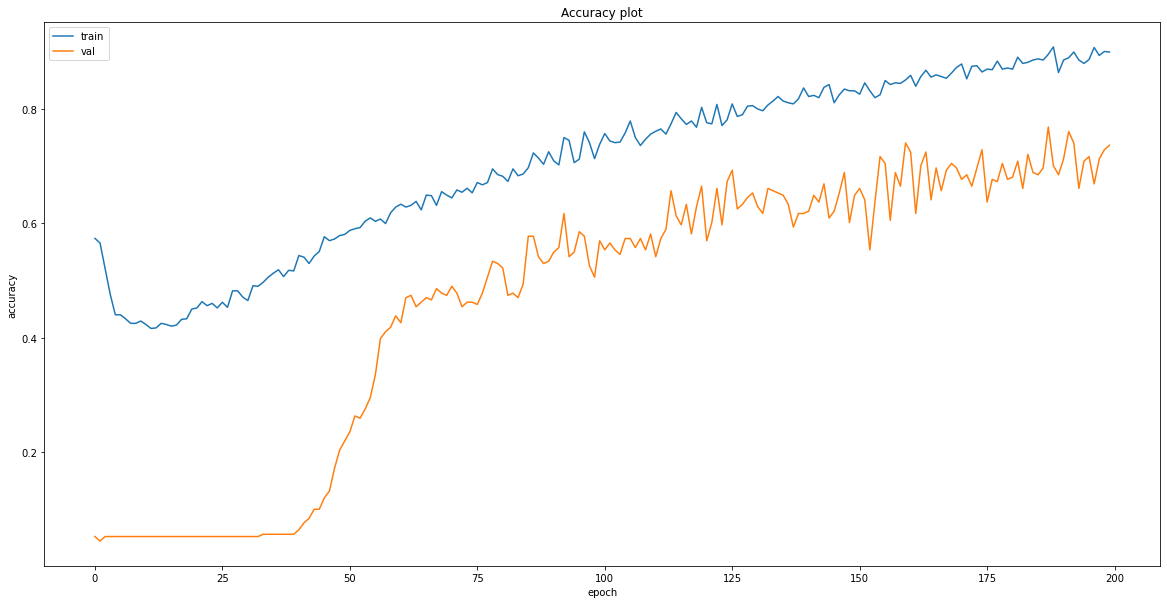

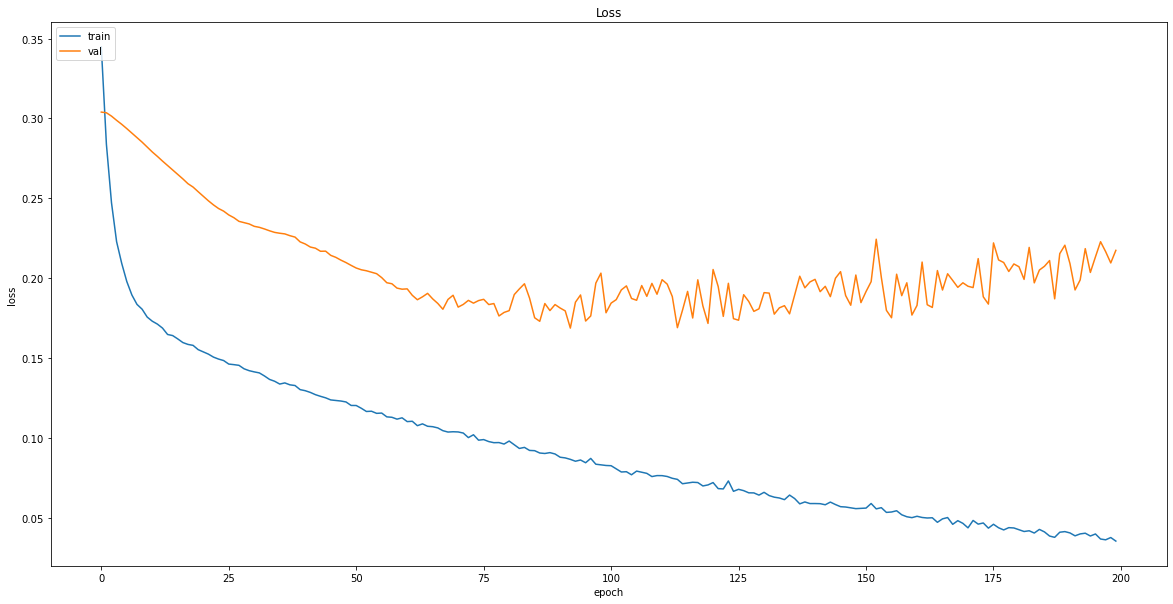

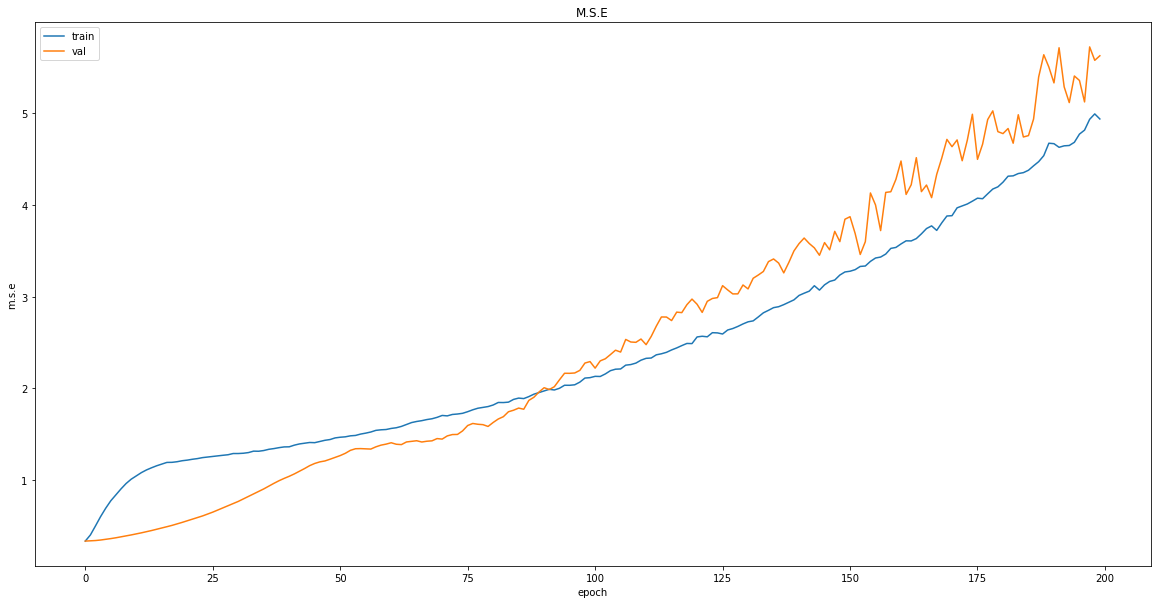

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [77]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1513 - accuracy: 0.7971 - mean_squared_error: 4.6556 - weighted_accuracy: 0.7971 - weighted_mean_squared_error: 4.6556
Test loss: 0.1513153612613678
Test accuracy: 0.7971014380455017


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 170, 1: 17, 0: 20})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [84]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


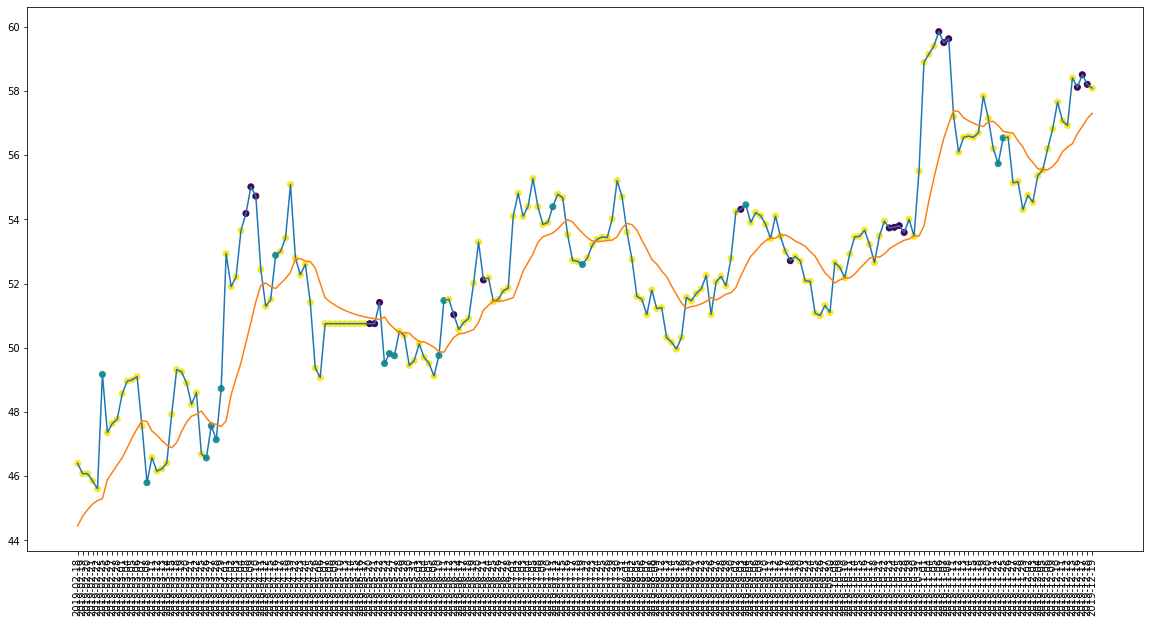

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

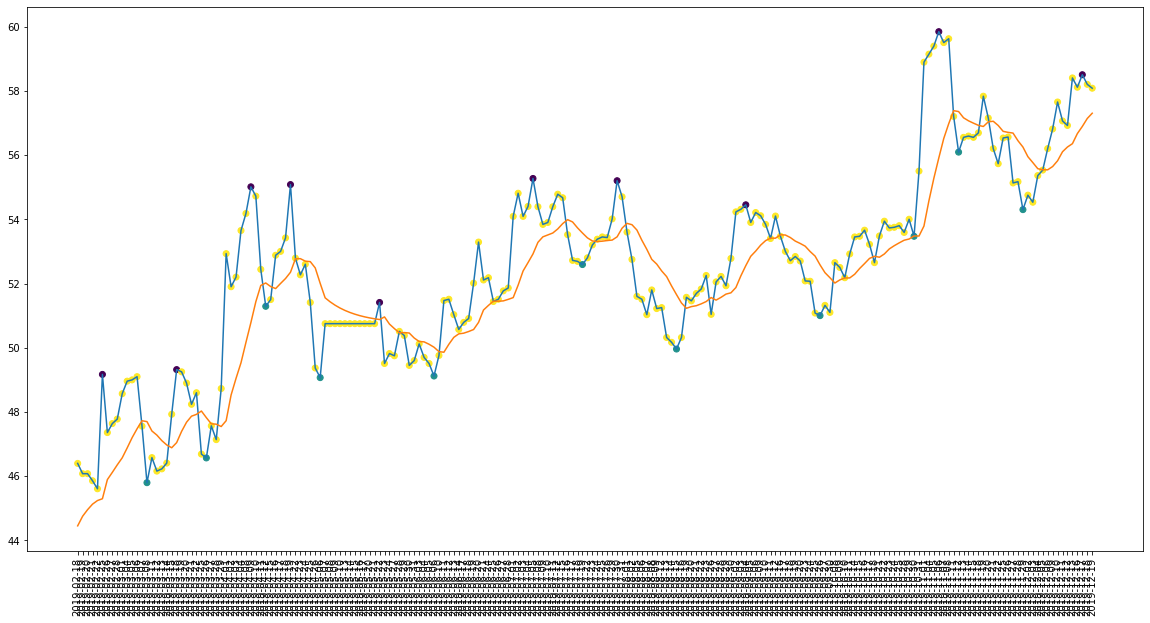

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 12
actual holds but predicted sell: 16
actual predicted holds: 158
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 40.0%
Percentage holds correct: 84.94623655913979%
actual buys: 11
actual sells: 10
actual holds: 186


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 85.0%
Percentage holds correct: 81.06508875739645%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $49.16999816894531
Shares owned at the moment: 202
Cash capital at the moment: $40.346435890198336


Stop Loss Activated!

Share price: $47.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9580.758078842164


Share price: $45.79999923706055
Shares owned at the moment: 208
Cash capital at the moment: $28.160637969971503


Price increase from previously bought: 17.972521434417477%
Share price: $54.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11266.609741271974


Share price: $52.88000106811523
Shares owned at the moment: 212
Cash capital at the moment: $25.220474208834275


Stop Loss Activated!

Share price: $51.40999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10894.16841194916


Share price: $49.5099983215332
Shares owned at the moment: 219
Cash capital at the moment: $21.661383044245667


Price increase from previously bought: 9.394183596574713%
Share price: $54.31000137329102
Shares owned at th

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


In [95]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.7548 - mean_squared_error: 5.1202 - weighted_accuracy: 0.7548 - weighted_mean_squared_error: 5.1202
Test loss: 0.15327154099941254
Test accuracy: 0.754807710647583


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 22, 2: 165, 1: 21})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [102]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,0,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,0,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


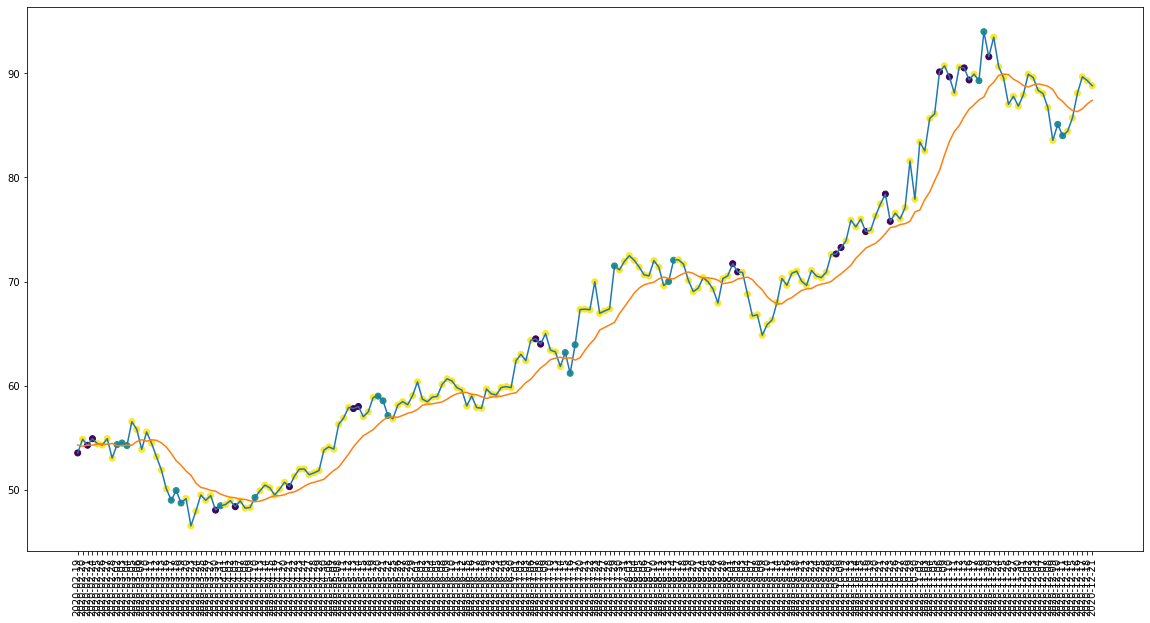

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

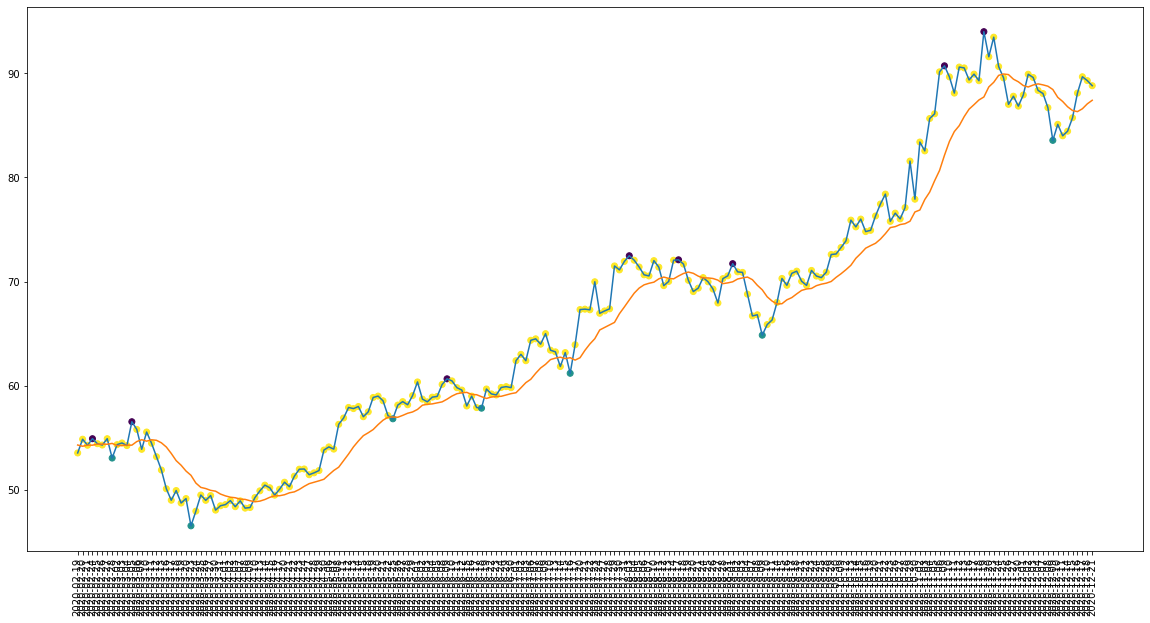

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 20
actual predicted holds: 154
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 25.0%
Percentage holds correct: 79.79274611398964%
actual buys: 7
actual sells: 8
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 50.0%
Percentage holds correct: 85.36585365853658%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.34000015258789
Shares owned at the moment: 183
Cash capital at the moment: $28.43336699962674


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9500.014970467566


Share price: $49.0
Shares owned at the moment: 193
Cash capital at the moment: $17.00822046756548


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8974.527291678427


Share price: $48.47000122070313
Shares owned at the moment: 184
Cash capital at the moment: $31.521246451373372


Price increase from previously bought: 18.921979990108852%
Share price: $57.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10637.474306456561


Share price: $59.0
Shares owned at the moment: 179
Cash capital at the moment: $47.43155645656043


Stop Loss Activated!

Share price: $57.13000106811523
Shares owned at the moment: 0
Cash capital at the moment: $10245.579504623405


Sh

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%
3,0.754808,14.285714285714286%,25.0%,79.79274611398964%,57.142857142857146%,50.0%,85.36585365853658%,29.34598367682447%,64.87407351390837%


## Walmart

In [111]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


In [112]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,labels
Date,,,,
2000-01-21,63.3750,65.176128,-85.271318,2.0
2000-01-24,62.4375,64.754801,-94.594595,2.0
2000-01-25,59.3750,63.927139,-83.606557,2.0
2000-01-26,61.1250,63.496041,-68.306011,2.0
2000-01-27,61.9375,63.256265,-61.202186,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4745, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2804 - accuracy: 0.5047 - mse: 0.4826 - weighted_accuracy: 0.3457 - weighted_mse: 0.5489 - val_loss: 0.3002 - val_accuracy: 0.0453 - val_mse: 0.3517 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3517
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2029 - accuracy: 0.2616 - mse: 0.8714 - weighted_accuracy: 0.4302 - weighted_mse: 0.8447 - val_loss: 0.2901 - val_accuracy: 0.0453 - val_mse: 0.3809 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3809
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.2558 - mse: 1.0670 - weighted_accuracy: 0.4892 - weighted_mse: 1.0390 - val_loss: 0.2794 - val_accuracy: 0.0453 - val_mse: 0.4165 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4165
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1813 - accuracy: 0.2595 - mse: 1.1751 - weighted_accuracy: 0.4945 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1420 - accuracy: 0.3238 - mse: 1.6398 - weighted_accuracy: 0.6813 - weighted_mse: 1.5305 - val_loss: 0.1947 - val_accuracy: 0.3235 - val_mse: 1.6321 - val_weighted_accuracy: 0.3235 - val_weighted_mse: 1.6321
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1423 - accuracy: 0.3185 - mse: 1.6957 - weighted_accuracy: 0.6865 - weighted_mse: 1.5894 - val_loss: 0.1987 - val_accuracy: 0.2887 - val_mse: 1.6535 - val_weighted_accuracy: 0.2887 - val_weighted_mse: 1.6535
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1408 - accuracy: 0.3393 - mse: 1.6894 - weighted_accuracy: 0.6960 - weighted_mse: 1.5861 - val_loss: 0.2029 - val_accuracy: 0.2603 - val_mse: 1.8138 - val_weighted_accuracy: 0.2603 - val_weighted_mse: 1.8138
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.3288 - mse: 1.7176 - weighted_accuracy: 0.6920 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1243 - accuracy: 0.4958 - mse: 2.0143 - weighted_accuracy: 0.7660 - weighted_mse: 1.9489 - val_loss: 0.1954 - val_accuracy: 0.3846 - val_mse: 2.0735 - val_weighted_accuracy: 0.3846 - val_weighted_mse: 2.0735
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.4623 - mse: 2.0650 - weighted_accuracy: 0.7558 - weighted_mse: 1.9905 - val_loss: 0.1888 - val_accuracy: 0.3973 - val_mse: 2.1593 - val_weighted_accuracy: 0.3973 - val_weighted_mse: 2.1593
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.4723 - mse: 2.0519 - weighted_accuracy: 0.7536 - weighted_mse: 1.9873 - val_loss: 0.1823 - val_accuracy: 0.4584 - val_mse: 2.1178 - val_weighted_accuracy: 0.4584 - val_weighted_mse: 2.1178
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1222 - accuracy: 0.5032 - mse: 2.0753 - weighted_accuracy: 0.7653 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1070 - accuracy: 0.5911 - mse: 2.3992 - weighted_accuracy: 0.8083 - weighted_mse: 2.3781 - val_loss: 0.1820 - val_accuracy: 0.4995 - val_mse: 2.5103 - val_weighted_accuracy: 0.4995 - val_weighted_mse: 2.5103
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.6120 - mse: 2.3759 - weighted_accuracy: 0.8012 - weighted_mse: 2.3718 - val_loss: 0.1906 - val_accuracy: 0.5058 - val_mse: 2.4092 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 2.4092
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1073 - accuracy: 0.5854 - mse: 2.4110 - weighted_accuracy: 0.7934 - weighted_mse: 2.3796 - val_loss: 0.1779 - val_accuracy: 0.5269 - val_mse: 2.3578 - val_weighted_accuracy: 0.5269 - val_weighted_mse: 2.3578
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1066 - accuracy: 0.6135 - mse: 2.4566 - weighted_accuracy: 0.8109 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0930 - accuracy: 0.6834 - mse: 2.8447 - weighted_accuracy: 0.8492 - weighted_mse: 2.8794 - val_loss: 0.1785 - val_accuracy: 0.5627 - val_mse: 2.9120 - val_weighted_accuracy: 0.5627 - val_weighted_mse: 2.9120
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0911 - accuracy: 0.6768 - mse: 2.8034 - weighted_accuracy: 0.8504 - weighted_mse: 2.8385 - val_loss: 0.1667 - val_accuracy: 0.6091 - val_mse: 3.0010 - val_weighted_accuracy: 0.6091 - val_weighted_mse: 3.0010
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0910 - accuracy: 0.6942 - mse: 2.8866 - weighted_accuracy: 0.8606 - weighted_mse: 2.9149 - val_loss: 0.1660 - val_accuracy: 0.6027 - val_mse: 2.9915 - val_weighted_accuracy: 0.6027 - val_weighted_mse: 2.9915
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0896 - accuracy: 0.6984 - mse: 2.8777 - weighted_accuracy: 0.8638 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.7463 - mse: 3.4874 - weighted_accuracy: 0.8851 - weighted_mse: 3.5125 - val_loss: 0.1645 - val_accuracy: 0.6438 - val_mse: 3.5559 - val_weighted_accuracy: 0.6438 - val_weighted_mse: 3.5559
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0769 - accuracy: 0.7489 - mse: 3.4534 - weighted_accuracy: 0.8933 - weighted_mse: 3.4725 - val_loss: 0.1543 - val_accuracy: 0.6828 - val_mse: 3.6670 - val_weighted_accuracy: 0.6828 - val_weighted_mse: 3.6670
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 0.7460 - mse: 3.4542 - weighted_accuracy: 0.8924 - weighted_mse: 3.4649 - val_loss: 0.1479 - val_accuracy: 0.7081 - val_mse: 3.5549 - val_weighted_accuracy: 0.7081 - val_weighted_mse: 3.5549
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0772 - accuracy: 0.7600 - mse: 3.5259 - weighted_accuracy: 0.8956 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0643 - accuracy: 0.7929 - mse: 4.2455 - weighted_accuracy: 0.9204 - weighted_mse: 4.2367 - val_loss: 0.1893 - val_accuracy: 0.6396 - val_mse: 4.2702 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 4.2702
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0633 - accuracy: 0.7990 - mse: 4.2815 - weighted_accuracy: 0.9171 - weighted_mse: 4.2505 - val_loss: 0.1620 - val_accuracy: 0.7208 - val_mse: 4.4228 - val_weighted_accuracy: 0.7208 - val_weighted_mse: 4.4228
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0627 - accuracy: 0.8156 - mse: 4.3361 - weighted_accuracy: 0.9233 - weighted_mse: 4.3037 - val_loss: 0.1772 - val_accuracy: 0.6649 - val_mse: 4.5152 - val_weighted_accuracy: 0.6649 - val_weighted_mse: 4.5152
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0646 - accuracy: 0.8003 - mse: 4.3132 - weighted_accuracy: 0.9177 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.17469459772109985
Test accuracy: 0.7291886210441589


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.1268597  -4.078386    2.1492121 ]
 [-2.4564297  -0.4873001  -0.27325672]
 [-0.44352832 -4.310881   -0.31530106]
 ...
 [-3.5563264   0.4662975  -1.3578273 ]
 [-2.8097043  -4.13038     2.6228921 ]
 [-2.2346168  -3.6942072   1.8526505 ]]


Counter({2: 760, 1: 99, 0: 90})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 37
actual holds but predicted buy: 92
actual holds but predicted sell: 86
actual predicted holds: 684
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 79.35034802784223%
actual buys: 43
actual sells: 44
actual holds: 862


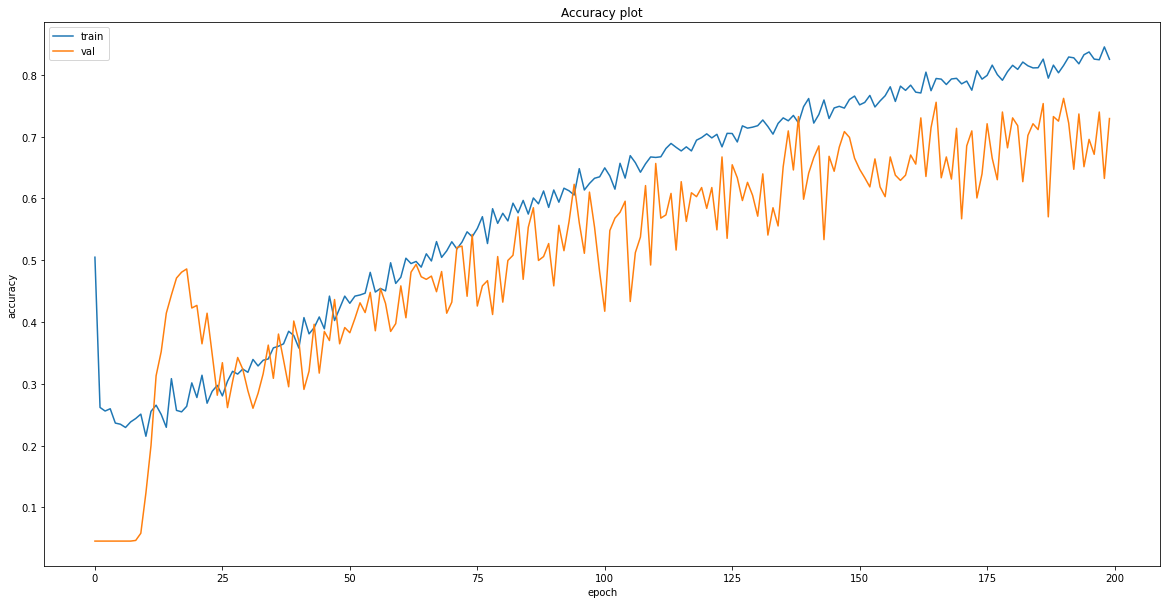

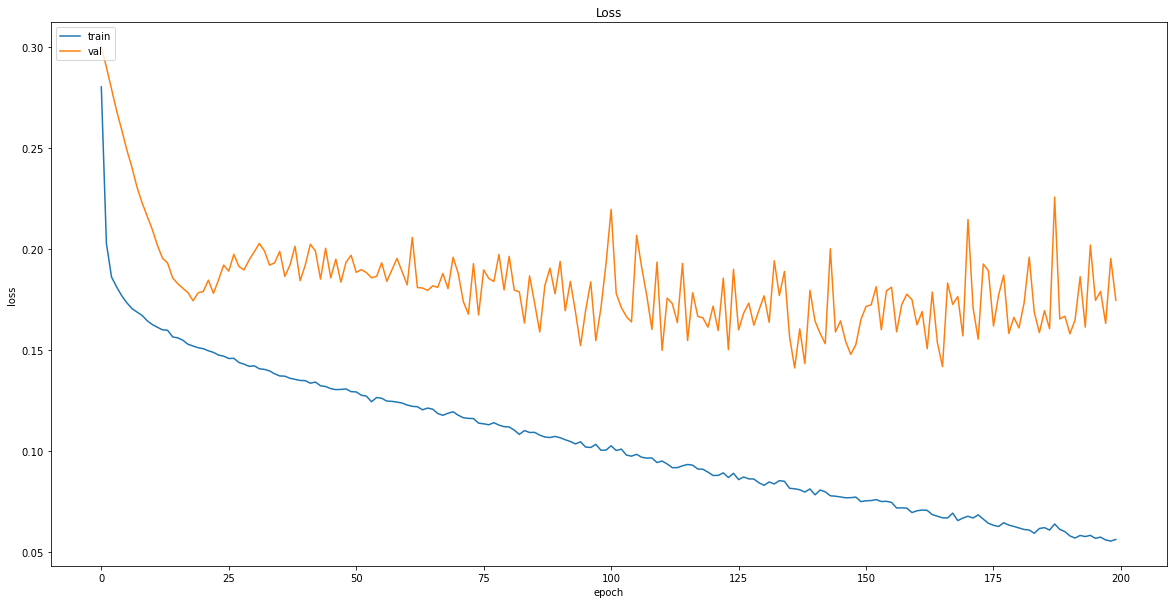

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('WMT_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/WMT_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [130]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1637 - accuracy: 0.7202 - mean_squared_error: 5.7212 - weighted_accuracy: 0.7202 - weighted_mean_squared_error: 5.7212
Test loss: 0.16374792158603668
Test accuracy: 0.7201834917068481


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 0: 31, 1: 21})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


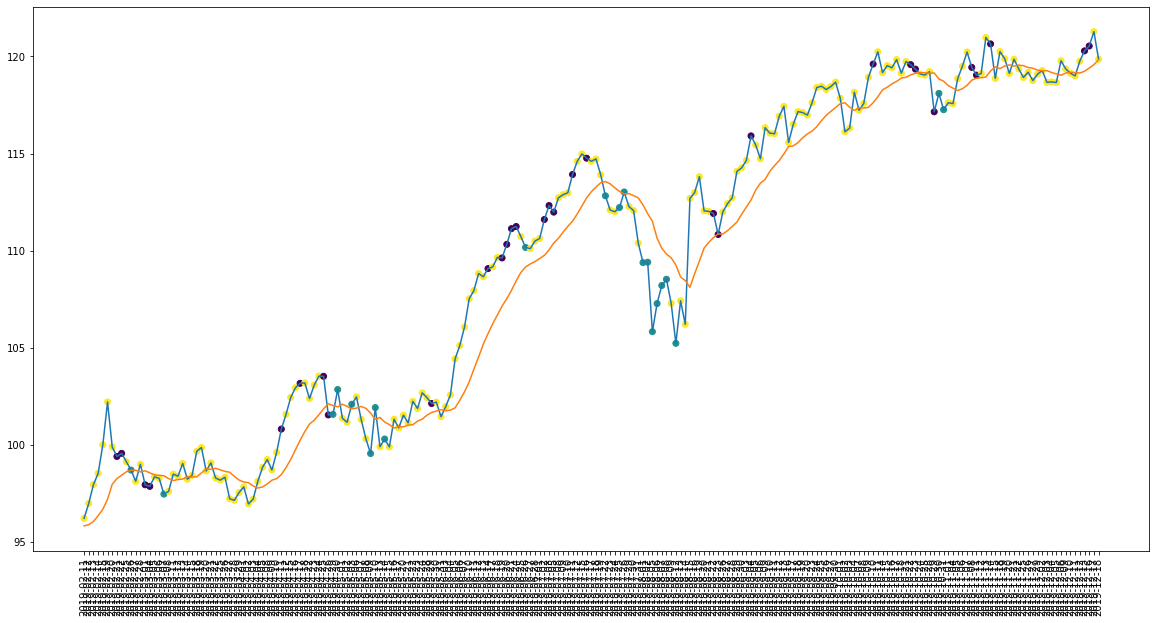

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

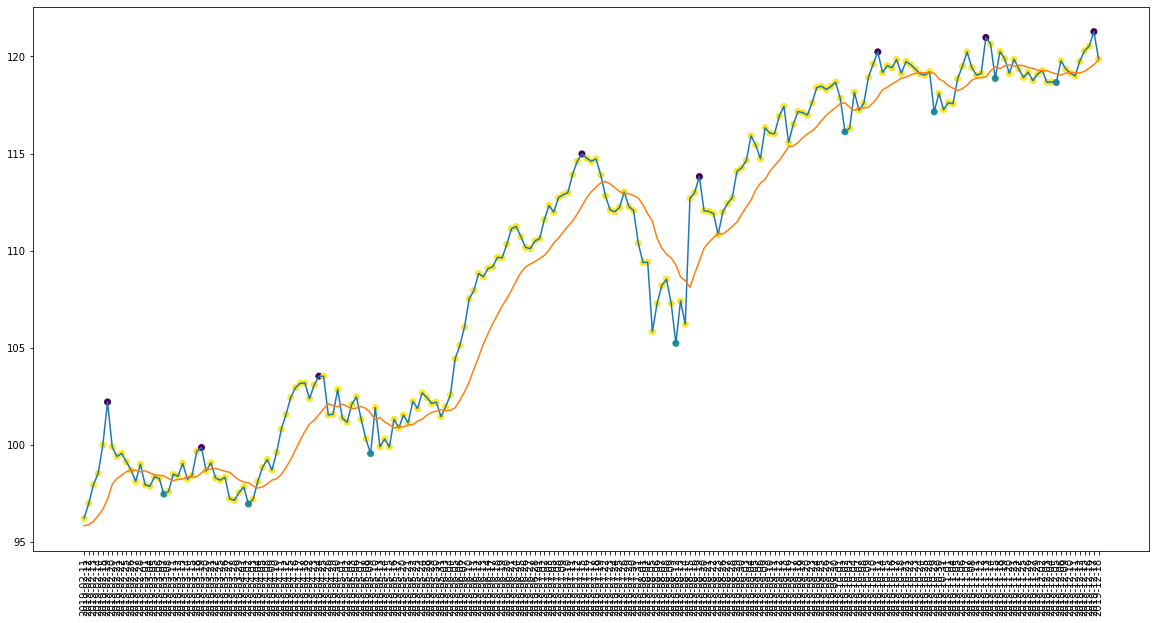

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 30
actual predicted holds: 154
Percentage buys correct: 37.5%
Percentage sells correct: 0.0%
Percentage holds correct: 76.23762376237623%
actual buys: 8
actual sells: 8
actual holds: 202


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 48.38709677419355%
Percentage holds correct: 86.06060606060606%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.69000244140624
Shares owned at the moment: 101
Cash capital at the moment: $4.898605239870449


Price increase from previously bought: 10.214689517330488%
Share price: $109.06999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10990.674382001878


Share price: $110.16000366210938
Shares owned at the moment: 99
Cash capital at the moment: $54.84295845603992


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10502.213433326722


Share price: $105.81999969482422
Shares owned at the moment: 98
Cash capital at the moment: $103.33497331619401


Price increase from previously bought: 5.4650306863536%
Share price: $111.91000366210938
Shares owned at the moment: 0
Cash capital at the moment: $11040.355586215974


Share price: $118.0999984741211
Shares owned at the moment: 93
Cash capital at the moment: $26.851653512954726




Capital at the end of test period: $11143.177515119552
profit gained:

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%
3,0.754808,14.285714285714286%,25.0%,79.79274611398964%,57.142857142857146%,50.0%,85.36585365853658%,29.34598367682447%,64.87407351390837%
4,0.720183,37.5%,0.0%,76.23762376237623%,57.142857142857146%,48.38709677419355%,86.06060606060606%,11.431775151195525%,23.7578138288879%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [147]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.7900 - mean_squared_error: 5.7108 - weighted_accuracy: 0.7900 - weighted_mean_squared_error: 5.7108
Test loss: 0.1516849398612976
Test accuracy: 0.7899543642997742


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 1: 24, 0: 16})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


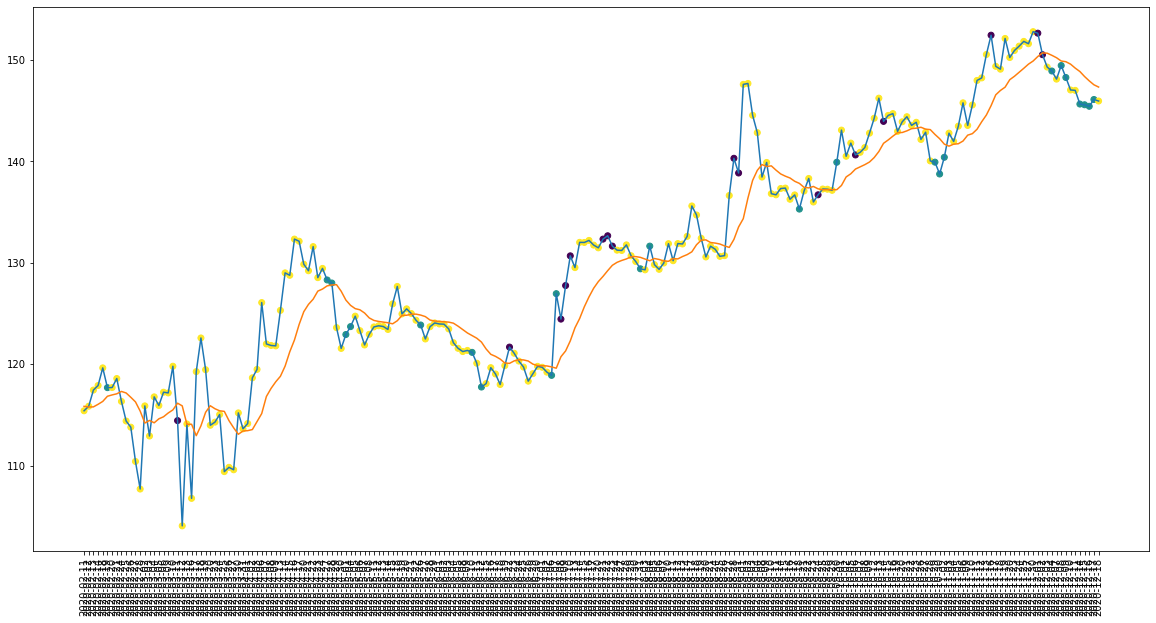

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

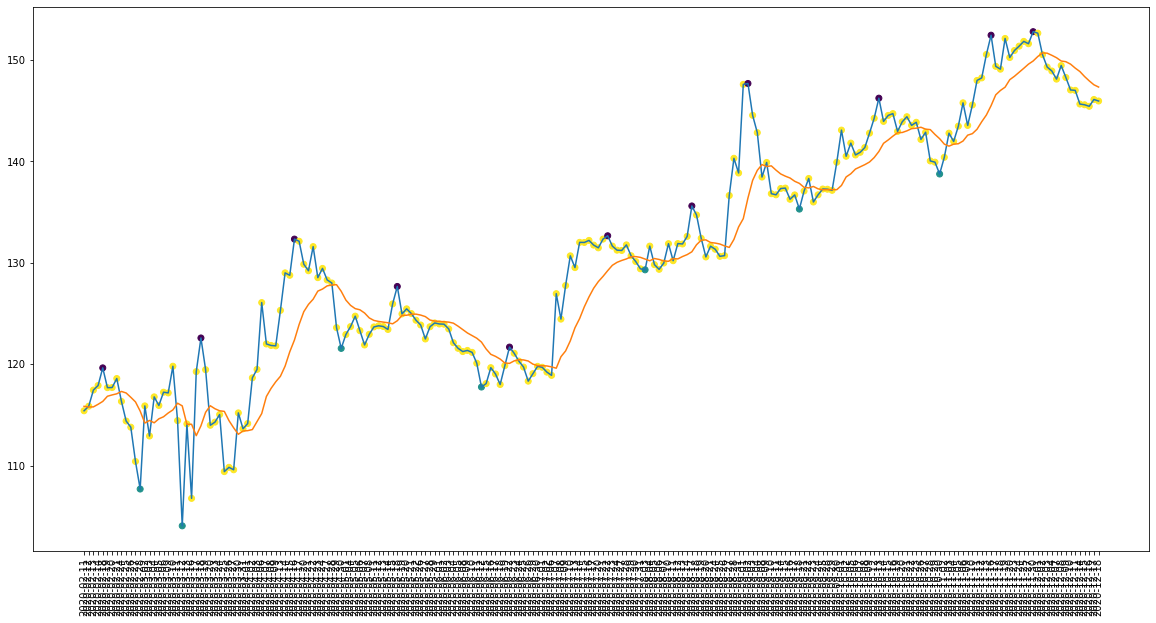

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 13
actual predicted holds: 167
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 83.08457711442786%
actual buys: 7
actual sells: 11
actual holds: 201


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 54.166666666666664%
Percentage sells correct: 43.75%
Percentage holds correct: 86.51685393258427%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $117.68000030517578
Shares owned at the moment: 84
Cash capital at the moment: $87.69589429473854


Stop Loss Activated!

Share price: $114.38999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9670.031753166199


Share price: $128.30000305175778
Shares owned at the moment: 75
Cash capital at the moment: $21.069648654938646


Stop Loss Activated!

Share price: $123.5999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9265.577034528733


Share price: $122.91999816894531
Shares owned at the moment: 75
Cash capital at the moment: $21.22492223548943


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $8827.440887458799


Share price: $117.73999786376952
Shares owned at the moment: 74
Cash capital at the moment: $90.72095597457883


Price increase from previously bought: 5.400656686721583%
Share price: $124.44000244140624
Shares owned at the moment: 0
Cash capital at the momen

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%
3,0.754808,14.285714285714286%,25.0%,79.79274611398964%,57.142857142857146%,50.0%,85.36585365853658%,29.34598367682447%,64.87407351390837%
4,0.720183,37.5%,0.0%,76.23762376237623%,57.142857142857146%,48.38709677419355%,86.06060606060606%,11.431775151195525%,23.7578138288879%
5,0.789954,42.857142857142854%,27.272727272727273%,83.08457711442786%,54.166666666666664%,43.75%,86.51685393258427%,11.627093883819544%,25.65490331684112%


## Fresh Del Monte Produce Inc

In [162]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


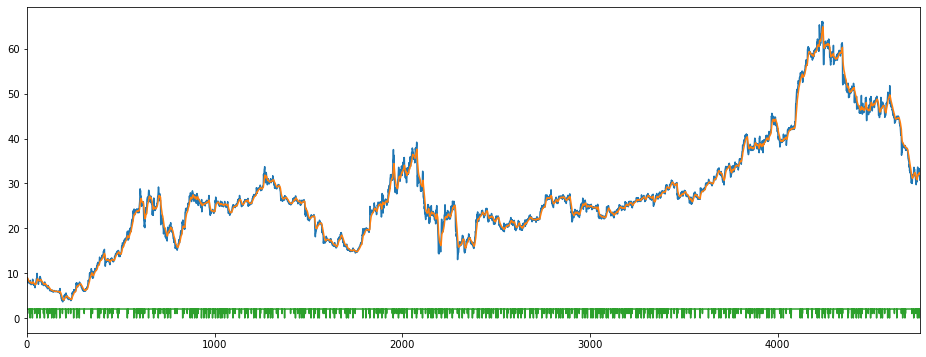

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [165]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2930 - accuracy: 0.5234 - mse: 0.4590 - weighted_accuracy: 0.2969 - weighted_mse: 0.5460 - val_loss: 0.2998 - val_accuracy: 0.0464 - val_mse: 0.3514 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3514
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2105 - accuracy: 0.3504 - mse: 0.8089 - weighted_accuracy: 0.4143 - weighted_mse: 0.8022 - val_loss: 0.2891 - val_accuracy: 0.0464 - val_mse: 0.3805 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3805
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1912 - accuracy: 0.2966 - mse: 1.0302 - weighted_accuracy: 0.4633 - weighted_mse: 1.0086 - val_loss: 0.2771 - val_accuracy: 0.0464 - val_mse: 0.4175 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4175
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1837 - accuracy: 0.2756 - mse: 1.1567 - weighted_accuracy: 0.4754 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1508 - accuracy: 0.3166 - mse: 1.5371 - weighted_accuracy: 0.6279 - weighted_mse: 1.4529 - val_loss: 0.1866 - val_accuracy: 0.3361 - val_mse: 1.5115 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 1.5115
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1502 - accuracy: 0.3509 - mse: 1.5185 - weighted_accuracy: 0.6260 - weighted_mse: 1.4427 - val_loss: 0.1907 - val_accuracy: 0.3087 - val_mse: 1.5179 - val_weighted_accuracy: 0.3087 - val_weighted_mse: 1.5179
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1487 - accuracy: 0.3625 - mse: 1.5267 - weighted_accuracy: 0.6483 - weighted_mse: 1.4496 - val_loss: 0.1897 - val_accuracy: 0.3109 - val_mse: 1.5542 - val_weighted_accuracy: 0.3109 - val_weighted_mse: 1.5542
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.3462 - mse: 1.5344 - weighted_accuracy: 0.6515 - weig

30/30 [==============================] - 0s 9ms/step - loss: 0.1324 - accuracy: 0.4808 - mse: 1.7233 - weighted_accuracy: 0.7406 - weighted_mse: 1.6605 - val_loss: 0.1923 - val_accuracy: 0.3709 - val_mse: 1.8051 - val_weighted_accuracy: 0.3709 - val_weighted_mse: 1.8051
Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.4955 - mse: 1.7422 - weighted_accuracy: 0.7352 - weighted_mse: 1.7035 - val_loss: 0.1847 - val_accuracy: 0.4268 - val_mse: 1.7121 - val_weighted_accuracy: 0.4268 - val_weighted_mse: 1.7121
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1313 - accuracy: 0.4718 - mse: 1.7446 - weighted_accuracy: 0.7409 - weighted_mse: 1.6834 - val_loss: 0.1736 - val_accuracy: 0.4826 - val_mse: 1.7856 - val_weighted_accuracy: 0.4826 - val_weighted_mse: 1.7856
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.4929 - mse: 1.7542 - weighted_accuracy: 0.7414 - weighted_mse: 1.6

Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1151 - accuracy: 0.5998 - mse: 2.0469 - weighted_accuracy: 0.7862 - weighted_mse: 2.0057 - val_loss: 0.1820 - val_accuracy: 0.4816 - val_mse: 2.1402 - val_weighted_accuracy: 0.4816 - val_weighted_mse: 2.1402
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1141 - accuracy: 0.5848 - mse: 2.0483 - weighted_accuracy: 0.7933 - weighted_mse: 2.0082 - val_loss: 0.1820 - val_accuracy: 0.4932 - val_mse: 2.1226 - val_weighted_accuracy: 0.4932 - val_weighted_mse: 2.1226
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1141 - accuracy: 0.5977 - mse: 2.1000 - weighted_accuracy: 0.7945 - weighted_mse: 2.0586 - val_loss: 0.1767 - val_accuracy: 0.5248 - val_mse: 2.1912 - val_weighted_accuracy: 0.5248 - val_weighted_mse: 2.1912
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1130 - accuracy: 0.5888 - mse: 2.0902 - weighted_accuracy: 0.7893 - weig

Epoch 116/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0979 - accuracy: 0.6636 - mse: 2.5041 - weighted_accuracy: 0.8403 - weighted_mse: 2.4869 - val_loss: 0.1734 - val_accuracy: 0.5532 - val_mse: 2.6134 - val_weighted_accuracy: 0.5532 - val_weighted_mse: 2.6134
Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0976 - accuracy: 0.6783 - mse: 2.4718 - weighted_accuracy: 0.8457 - weighted_mse: 2.4655 - val_loss: 0.1713 - val_accuracy: 0.5743 - val_mse: 2.6107 - val_weighted_accuracy: 0.5743 - val_weighted_mse: 2.6107
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0964 - accuracy: 0.6657 - mse: 2.5277 - weighted_accuracy: 0.8429 - weighted_mse: 2.5106 - val_loss: 0.1638 - val_accuracy: 0.6112 - val_mse: 2.6021 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 2.6021
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0957 - accuracy: 0.6770 - mse: 2.5704 - weighted_accuracy: 0.8525 - 

Epoch 145/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0840 - accuracy: 0.7281 - mse: 3.1458 - weighted_accuracy: 0.8730 - weighted_mse: 3.1195 - val_loss: 0.1707 - val_accuracy: 0.6333 - val_mse: 3.3459 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 3.3459
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0832 - accuracy: 0.7482 - mse: 3.1598 - weighted_accuracy: 0.8823 - weighted_mse: 3.1542 - val_loss: 0.1664 - val_accuracy: 0.6660 - val_mse: 3.6489 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 3.6489
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0802 - accuracy: 0.7442 - mse: 3.1816 - weighted_accuracy: 0.8880 - weighted_mse: 3.1802 - val_loss: 0.1794 - val_accuracy: 0.6164 - val_mse: 3.3555 - val_weighted_accuracy: 0.6164 - val_weighted_mse: 3.3555
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.7471 - mse: 3.1677 - weighted_accuracy: 0.8945 - 

Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0682 - accuracy: 0.8008 - mse: 3.9898 - weighted_accuracy: 0.9125 - weighted_mse: 3.9119 - val_loss: 0.1733 - val_accuracy: 0.6891 - val_mse: 4.4296 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 4.4296
Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0690 - accuracy: 0.7964 - mse: 4.0520 - weighted_accuracy: 0.9126 - weighted_mse: 3.9661 - val_loss: 0.1846 - val_accuracy: 0.6533 - val_mse: 4.1712 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 4.1712
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0669 - accuracy: 0.7948 - mse: 4.0087 - weighted_accuracy: 0.9156 - weighted_mse: 3.9727 - val_loss: 0.1692 - val_accuracy: 0.6849 - val_mse: 4.4738 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 4.4738
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.7987 - mse: 4.1562 - weighted_accuracy: 0.9170 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.17309194803237915
Test accuracy: 0.7397260069847107


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.3376713  -1.6623805   1.0989703 ]
 [ 0.5225322  -2.9981792  -1.6720293 ]
 [-3.1410263  -1.3982836   0.9395724 ]
 ...
 [-0.650247   -2.9285138  -0.19603477]
 [-1.7842287  -4.1809993   0.8912284 ]
 [-1.4459702  -2.1313725   0.44192982]]


Counter({2: 768, 0: 87, 1: 94})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 90
actual holds but predicted sell: 80
actual predicted holds: 692
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 80.2784222737819%
actual buys: 44
actual sells: 43
actual holds: 862


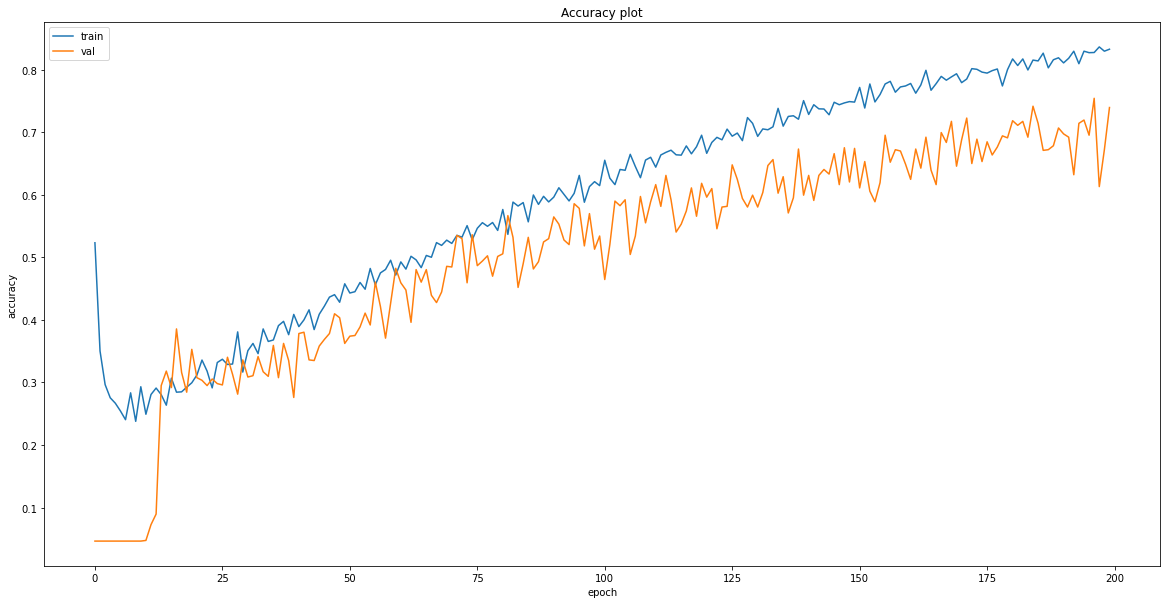

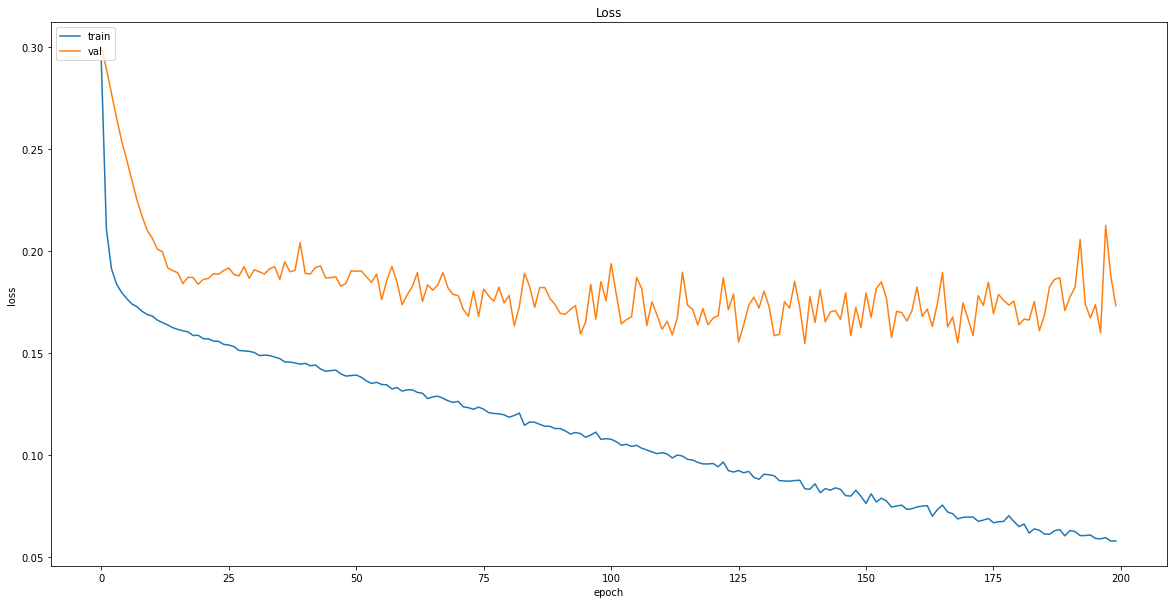

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [180]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.7385 - mean_squared_error: 6.3580 - weighted_accuracy: 0.7385 - weighted_mean_squared_error: 6.3580
Test loss: 0.1915425807237625
Test accuracy: 0.7385321259498596


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 172, 1: 29, 0: 17})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


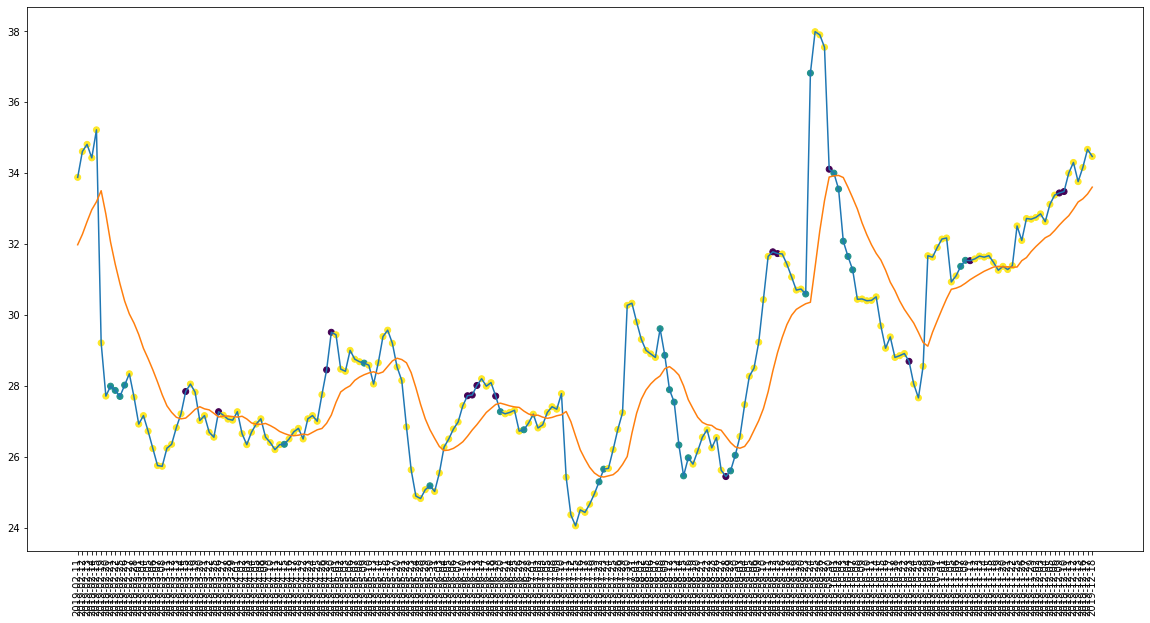

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

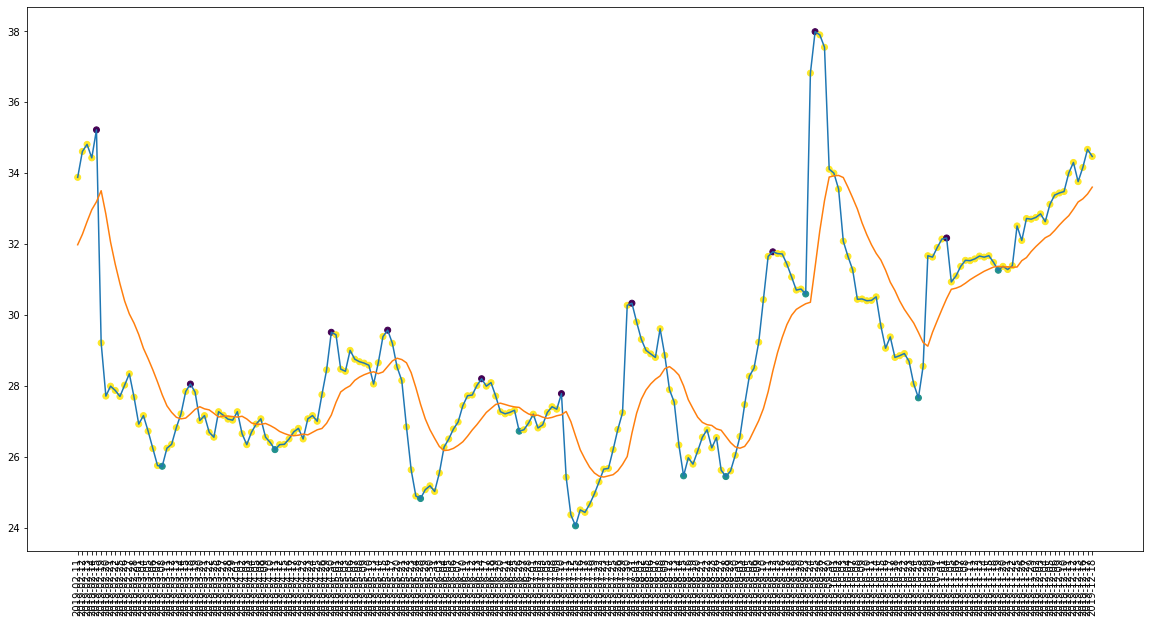

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 27
actual holds but predicted sell: 14
actual predicted holds: 157
Percentage buys correct: 20.0%
Percentage sells correct: 20.0%
Percentage holds correct: 79.29292929292929%
actual buys: 10
actual sells: 10
actual holds: 198


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 44.827586206896555%
Percentage sells correct: 43.75%
Percentage holds correct: 83.72093023255815%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $26.35000038146973
Shares owned at the moment: 362
Cash capital at the moment: $0.39165532016522775


Price increase from previously bought: 7.673538569949523%
Share price: $28.45000076293945
Shares owned at the moment: 0
Cash capital at the moment: $10270.969955744738


Share price: $28.63999938964844
Shares owned at the moment: 357
Cash capital at the moment: $18.3728542394565


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9573.90273856353


Share price: $25.18000030517578
Shares owned at the moment: 379
Cash capital at the moment: $4.438767583840672


Price increase from previously bought: 9.78545686175767%
Share price: $27.71999931335449
Shares owned at the m

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%
3,0.754808,14.285714285714286%,25.0%,79.79274611398964%,57.142857142857146%,50.0%,85.36585365853658%,29.34598367682447%,64.87407351390837%
4,0.720183,37.5%,0.0%,76.23762376237623%,57.142857142857146%,48.38709677419355%,86.06060606060606%,11.431775151195525%,23.7578138288879%
5,0.789954,42.857142857142854%,27.272727272727273%,83.08457711442786%,54.166666666666664%,43.75%,86.51685393258427%,11.627093883819544%,25.65490331684112%
6,0.738532,20.0%,20.0%,79.29292929292929%,44.827586206896555%,43.75%,83.72093023255815%,26.41689095023132%,1.1819906801032993%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [197]:
df.drop(['OBV_7'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.7306 - mean_squared_error: 5.8256 - weighted_accuracy: 0.7306 - weighted_mean_squared_error: 5.8256
Test loss: 0.16319382190704346
Test accuracy: 0.7305936217308044


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 22, 2: 180, 1: 17})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


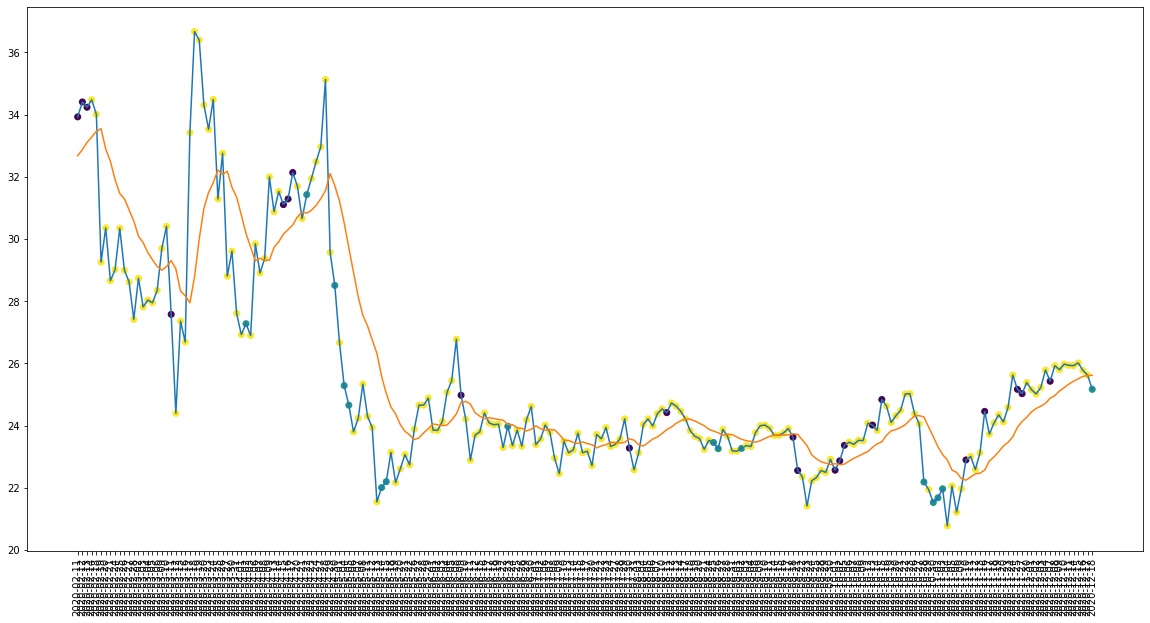

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

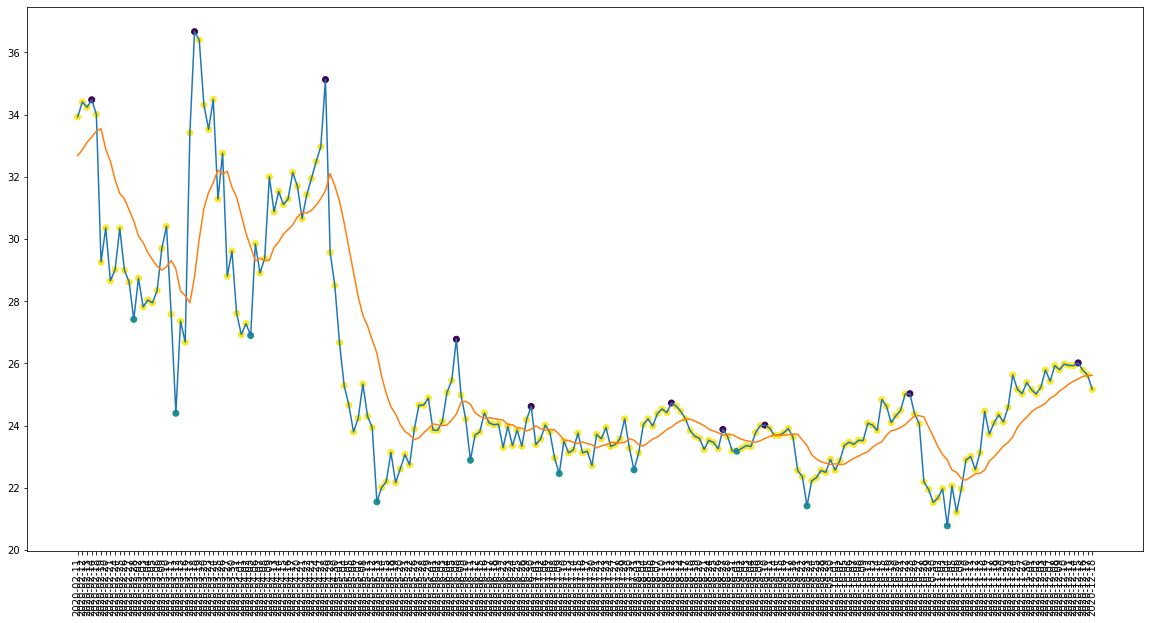

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 17
actual holds but predicted sell: 22
actual predicted holds: 160
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 80.40201005025126%
actual buys: 10
actual sells: 10
actual holds: 199


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 75.0%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 81.11111111111111%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.28000068664551
Shares owned at the moment: 365
Cash capital at the moment: $15.417448685167983


Price increase from previously bought: 13.726839999765449%
Share price: $31.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $11339.341008350846


Share price: $31.43000030517578
Shares owned at the moment: 359
Cash capital at the moment: $24.941630991455895


Stop Loss Activated!

Share price: $29.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10611.378539234634


Share price: $28.51000022888184
Shares owned at the moment: 371
Cash capital at the moment: $5.081126585953825


Stop Loss Activated!

Share price: $26.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9872.44108731317


Share price: $25.290000915527344
Shares owned at the moment: 389
Cash capital at the moment: $7.576752693646995


Stop Loss Activated!

Share price: $23.79999923706055
Shares owned at the moment: 0
Cash capital at the mom

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.719807,27.272727272727273%,18.181818181818183%,77.83783783783784%,75.0%,65.38461538461539%,86.95652173913044%,33.065136389160145%,55.56771999603271%
1,0.745192,22.22222222222222%,30.0%,79.36507936507937%,44.44444444444444%,47.22222222222222%,84.04907975460122%,1.3343840423583424%,67.54069125000002%
2,0.797101,27.272727272727273%,40.0%,84.94623655913979%,58.8235294117647%,85.0%,81.06508875739645%,18.56868447480205%,24.380335833320625%
3,0.754808,14.285714285714286%,25.0%,79.79274611398964%,57.142857142857146%,50.0%,85.36585365853658%,29.34598367682447%,64.87407351390837%
4,0.720183,37.5%,0.0%,76.23762376237623%,57.142857142857146%,48.38709677419355%,86.06060606060606%,11.431775151195525%,23.7578138288879%
5,0.789954,42.857142857142854%,27.272727272727273%,83.08457711442786%,54.166666666666664%,43.75%,86.51685393258427%,11.627093883819544%,25.65490331684112%
6,0.738532,20.0%,20.0%,79.29292929292929%,44.827586206896555%,43.75%,83.72093023255815%,26.41689095023132%,1.1819906801032993%
7,0.730594,0.0%,0.0%,80.40201005025126%,75.0%,36.36363636363637%,81.11111111111111%,-12.508856921172193%,-26.14299892369747%


In [212]:
experiment

'No OBV LSTM Time Series - noncyclic'

In [213]:
log.to_csv('{}.csv'.format(experiment))